# Datan jako ja visualisointi

Tämä notebook jakaa skaalatun datan training-, validation- ja test-osiin sekä visualisoi jaon tulokset.

## Kirjastojen tuonti

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime

# Poista pandas rajoitukset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

## Datan jako

Seuraavaksi luemme skaalatun datan ja jaamme sen kolmeen osaan:
- Training data (70%): Käytetään mallin opettamiseen
- Validation data (15%): Käytetään hyperparametrien optimointiin
- Test data (15%): Käytetään lopulliseen mallin arviointiin

Datan jako tehdään säilyttäen luokkien suhteet (stratified split).

In [4]:
# Lue skaalattu data
input_file = '../Data/scaledHydraulicData.csv'
print(f"\nLuetaan data tiedostosta: {input_file}")
df = pd.read_csv(input_file)

# Tulosta alkuperäisen datan tiedot
print(f"\nAlkuperäinen data:")
print(f"- Rivejä yhteensä: {len(df)}")
print("\nLuokkajakauma:")
for state, count in df['state'].value_counts().items():
    print(f"- {state}: {count} kpl")

# Jaa ensin testidataan (15%) ja väliaikaiseen dataan (85%)
temp_data, test_data = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42,
    stratify=df['state']  # Säilytä luokkien suhteet
)

# Jaa väliaikainen data training (70/85) ja validation (15/85) osiin
train_data, val_data = train_test_split(
    temp_data,
    test_size=0.15/0.85,  # Suhteellinen osuus jäljellä olevasta datasta
    random_state=42,
    stratify=temp_data['state']  # Säilytä luokkien suhteet
)

# Tallenna datasetit
train_file = '../Data/trainingData.csv'
val_file = '../Data/validationData.csv'
test_file = '../Data/testData.csv'

train_data.to_csv(train_file, index=False)
val_data.to_csv(val_file, index=False)
test_data.to_csv(test_file, index=False)


Luetaan data tiedostosta: ../Data/scaledHydraulicData.csv

Alkuperäinen data:
- Rivejä yhteensä: 9924

Luokkajakauma:
- normal_digging: 3661 kpl
- overload: 2981 kpl
- normal_full: 1193 kpl
- normal_empty: 1099 kpl
- hose_break: 990 kpl


## Yhteenveto jaetusta datasta

Tarkistetaan jokaisen datasetin koko ja luokkajakauma.
- Varmistetaan oikeat prosenttiosuudet
- Tarkistetaan rivimäärät
- Analysoidaan luokkajakaumat jokaisessa datasetissä

In [5]:
# Tulosta yhteenveto
print("\nDatan jako valmis!")
print("------------------")
print(f"Training data ({train_file}):")
print(f"- Rivejä: {len(train_data)} ({len(train_data)/len(df)*100:.1f}%)")
print("Luokkajakauma:")
for state, count in train_data['state'].value_counts().items():
    print(f"- {state}: {count} kpl")

print(f"\nValidation data ({val_file}):")
print(f"- Rivejä: {len(val_data)} ({len(val_data)/len(df)*100:.1f}%)")
print("Luokkajakauma:")
for state, count in val_data['state'].value_counts().items():
    print(f"- {state}: {count} kpl")

print(f"\nTest data ({test_file}):")
print(f"- Rivejä: {len(test_data)} ({len(test_data)/len(df)*100:.1f}%)")
print("Luokkajakauma:")
for state, count in test_data['state'].value_counts().items():
    print(f"- {state}: {count} kpl")


Datan jako valmis!
------------------
Training data (../Data/trainingData.csv):
- Rivejä: 6946 (70.0%)
Luokkajakauma:
- normal_digging: 2563 kpl
- overload: 2087 kpl
- normal_full: 835 kpl
- normal_empty: 769 kpl
- hose_break: 692 kpl

Validation data (../Data/validationData.csv):
- Rivejä: 1489 (15.0%)
Luokkajakauma:
- normal_digging: 549 kpl
- overload: 447 kpl
- normal_full: 179 kpl
- normal_empty: 165 kpl
- hose_break: 149 kpl

Test data (../Data/testData.csv):
- Rivejä: 1489 (15.0%)
Luokkajakauma:
- normal_digging: 549 kpl
- overload: 447 kpl
- normal_full: 179 kpl
- normal_empty: 165 kpl
- hose_break: 149 kpl


## Luokkasuhteiden tarkistus

Varmistetaan, että luokkasuhteet säilyivät samanlaisina kaikissa osajoukoissa.
- Lasketaan luokkien osuudet alkuperäisessä datassa
- Verrataan osuuksia training-, validation- ja test-dataseteissä
- Tarkistetaan, että erot ovat pieniä (< 1%)

In [6]:
# Tarkista luokkasuhteiden säilyminen
print("\nLuokkasuhteiden tarkistus:")
print("---------------------------")
original_ratios = df['state'].value_counts() / len(df)
train_ratios = train_data['state'].value_counts() / len(train_data)
val_ratios = val_data['state'].value_counts() / len(val_data)
test_ratios = test_data['state'].value_counts() / len(test_data)

max_diff = max(
    abs(original_ratios - train_ratios).max(),
    abs(original_ratios - val_ratios).max(),
    abs(original_ratios - test_ratios).max()
)

if max_diff < 0.01:
    print("✓ Luokkasuhteet säilyivät hyvin kaikissa osajoukoissa")
else:
    print("⚠️ Luokkasuhteissa on pieniä eroja osajoukoissa")


Luokkasuhteiden tarkistus:
---------------------------
✓ Luokkasuhteet säilyivät hyvin kaikissa osajoukoissa


## Datan visualisointi

Luodaan kolme kuvaajaa datan analysointia varten:

1. Piirakkadiagrammi
   - Näyttää datasettien suhteelliset koot
   - Varmistaa 70-15-15 jaon toteutumisen

2. Viulukuvaaja (Violin Plot)
   - Näyttää numeeristen muuttujien jakaumat
   - Visualisoi muuttujien keskiarvot ja hajonnat
   - Paljastaa mahdolliset poikkeavat havainnot

3. Pylväsdiagrammi
   - Vertailee luokkien jakaumia eri dataseteissä
   - Osoittaa stratified split -menetelmän toimivuuden
   - Varmistaa tasapainoisen luokkajakauman

Kuvaajat tallennetaan PNG-muodossa myöhempää käyttöä varten.

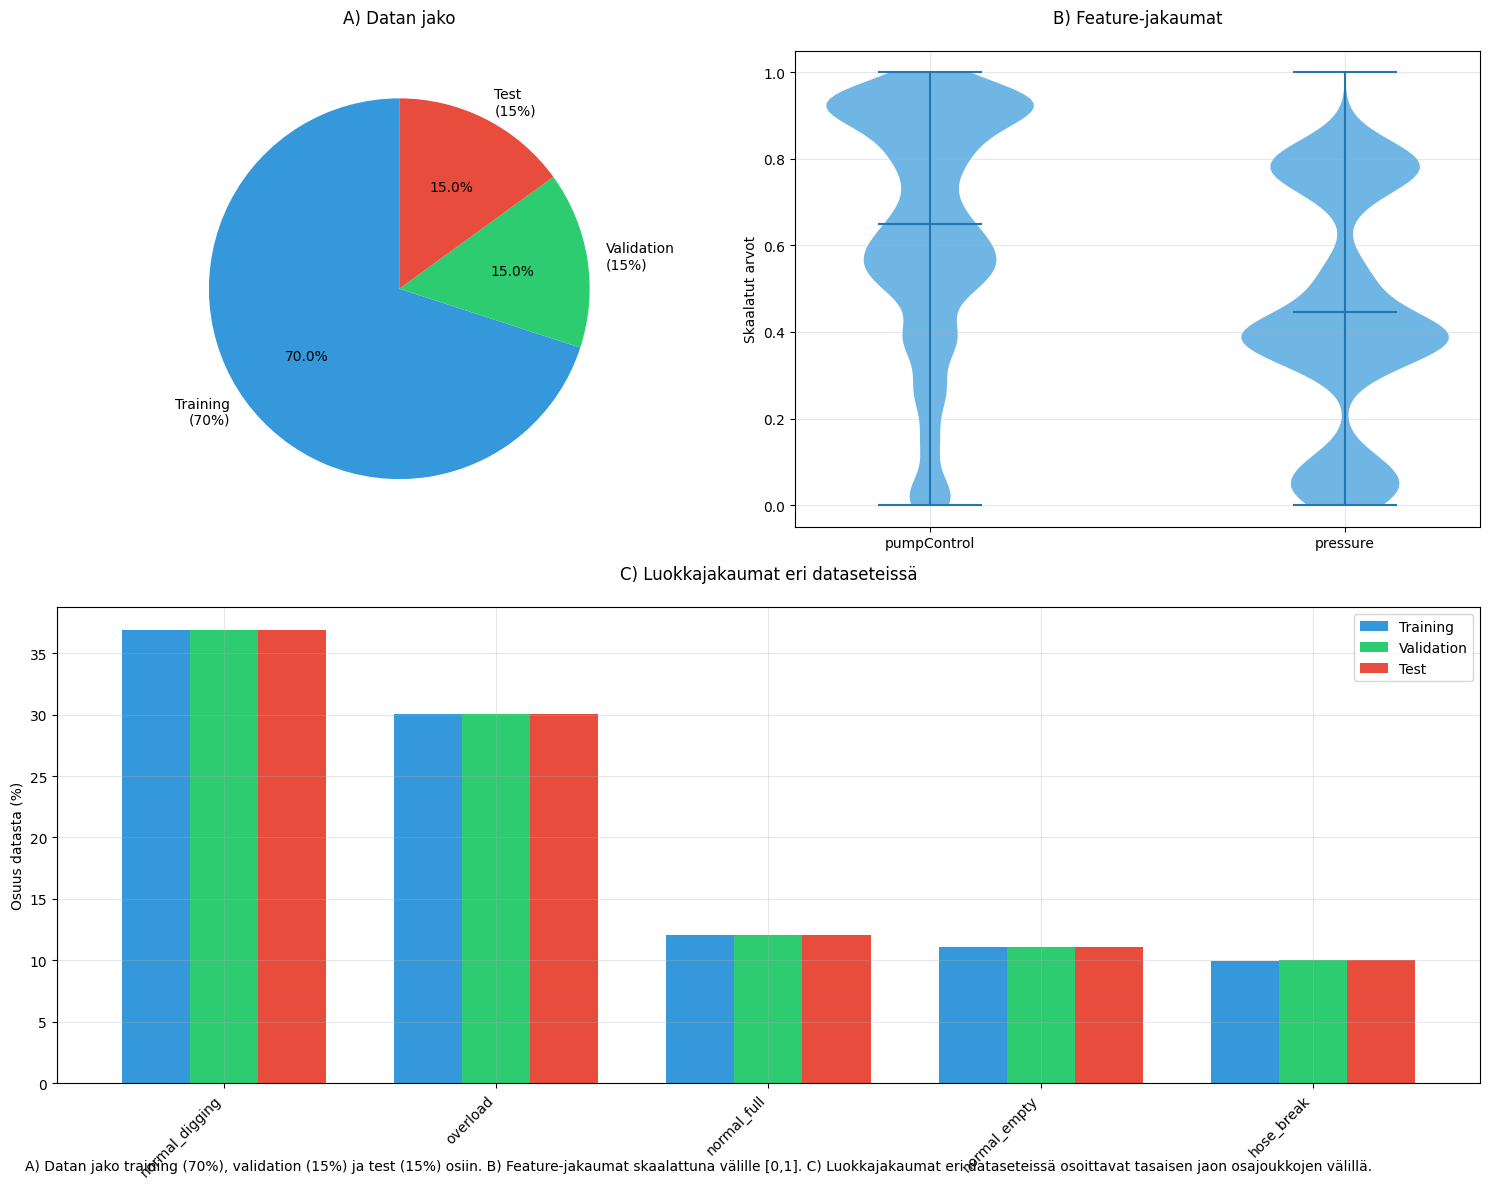

Visualisointi tallennettu: Visualization/dataSplitAnalysis.png


In [9]:
# Määritä visualisoinnin tyylit
plt.style.use('default')
colors_split = ['#3498db', '#2ecc71', '#e74c3c']  # Sininen, vihreä, punainen

# Luo kuva ja määritä asettelu
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# === KUVAAJA A: DATAN JAKO ===
# Piirakkadiagrammi näyttää datan jaon suhteelliset osuudet
ax1 = fig.add_subplot(gs[0, 0])
sizes = [len(train_data), len(val_data), len(test_data)]
labels = ['Training\n(70%)', 'Validation\n(15%)', 'Test\n(15%)']

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors_split, 
                                  autopct='%1.1f%%', startangle=90, 
                                  textprops={'fontsize': 10})

ax1.set_title('A) Datan jako', pad=20, fontsize=12)

# === KUVAAJA B: FEATURE-JAKAUMAT ===
# Viulukuvaaja näyttää numeeristen muuttujien jakaumat
ax2 = fig.add_subplot(gs[0, 1])
features = ['pumpControl', 'pressure']
positions = [1, 2]
violin_parts = ax2.violinplot([train_data[feature] for feature in features],
                            positions, showmeans=True)

for pc in violin_parts['bodies']:
    pc.set_facecolor(colors_split[0])
    pc.set_alpha(0.7)

ax2.set_xticks(positions)
ax2.set_xticklabels(features)
ax2.set_title('B) Feature-jakaumat', pad=20)
ax2.set_ylabel('Skaalatut arvot')
ax2.grid(True, alpha=0.3)

# === KUVAAJA C: LUOKKAJAKAUMAT ===
# Pylväsdiagrammi vertailee luokkien jakaumia eri dataseteissä
ax3 = fig.add_subplot(gs[1, :])

train_dist = train_data['state'].value_counts() / len(train_data) * 100
val_dist = val_data['state'].value_counts() / len(val_data) * 100
test_dist = test_data['state'].value_counts() / len(test_data) * 100

states = train_dist.index
x = np.arange(len(states))
width = 0.25

ax3.bar(x - width, train_dist, width, label='Training', color=colors_split[0])
ax3.bar(x, val_dist, width, label='Validation', color=colors_split[1])
ax3.bar(x + width, test_dist, width, label='Test', color=colors_split[2])

ax3.set_ylabel('Osuus datasta (%)')
ax3.set_title('C) Luokkajakaumat eri dataseteissä', pad=20)
ax3.set_xticks(x)
ax3.set_xticklabels(states, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Lisää kuvan selitys
plt.figtext(0.02, 0.02, 
            'A) Datan jako training (70%), validation (15%) ja test (15%) osiin. ' +
            'B) Feature-jakaumat skaalattuna välille [0,1]. ' +
            'C) Luokkajakaumat eri dataseteissä osoittavat tasaisen jaon osajoukkojen välillä.',
            wrap=True, horizontalalignment='left', fontsize=10)

# Säädä asettelua ja tallenna
plt.tight_layout()
plt.savefig('../Visualization/dataSplitAnalysis.png',
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()

print("Visualisointi tallennettu: Visualization/dataSplitAnalysis.png")

## Yhteenveto

Datan jako ja visualisointi on nyt valmis:
1. Data on jaettu kolmeen osaan säilyttäen luokkien suhteet
2. Jaon tulokset on tallennettu CSV-tiedostoihin
3. Visualisoinnit on tallennettu PNG-muodossa

Seuraavaksi voidaan siirtyä koneoppimismallin rakentamiseen käyttäen näitä datasettejä.